In [1]:
import pyhdfs
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

### 包成function

In [2]:
'''
讀取本地CSV檔
'''
def local_csv(df):
    # 將date欄位轉 str，並將/替換-，統一時間格式
    df['Date'] = df['Date'].astype(str).str.replace("/","-")
    # 判斷是否需進行民國轉西元
    len_date = len(df['Date'].values[0].split("-")[0])
    if len_date==4:
        pass
    else:
        df['Date'] = df['Date'].apply(lambda data: str(int(data[0:3])+1911)+season(data[3:]))
    return df

In [17]:
'''
比較當日收盤價與3日移動平均線
當日收盤價 > 3日移動平均線 --> 買進
當日收盤價 < 3日移動平均線 --> 賣出

固定區間內的收益
'''

def buy_fun(df_new):
    buy=[]
    sell=[]
    count=-1
    for i in range(1,len(df_new)+1):
        # 當日收盤價大於3日MA。則買進(buy放收盤價,sell放nan)並計1
        if df_new['Close'][i]>df_new['3D'][i]:
            sell.append(np.nan)
            buy.append(df_new['Close'][i])
            count = 1
        # 當日收盤價小於3日MA，若之前有買進，則賣出(buy放nan,sell放收盤價)。並計0   
        elif df_new['Close'][i]<df_new['3D'][i]:
            buy.append(np.nan)
            if count ==1:
                sell.append(df_new['Close'][i])
                count = 0
            else:
                sell.append(np.nan)
        # 當日收盤價等於3日MA，啥都不做
        else:
            buy.append(np.nan)
            sell.append(np.nan)
    df_new['buy'] = buy
    df_new['sell'] = sell
    
    #print(buy)
    #print(sell)
    
    # 當日收盤價*剩餘股數
    count_buy = len(np.array(buy)[~np.isnan(np.array(buy))])
    count_sell = len(np.array(sell)[~np.isnan(np.array(sell))])
    re = df_new['Close'][len(df_new)]*(count_buy-count_sell)
    #print(count_buy,count_sell,re)
    
    # 賣出總額 - 買進總額 - 當日收盤價*剩餘股數
    buy_total = np.nansum(np.array(buy))
    sell_total = np.nansum(np.array(sell))
    get_money = ((sell_total-buy_total+re)/df_new['Close'][len(df_new)])*100
    #print(buy_total,sell_total,re,get_money)
    
    return get_money

In [18]:
'''
total 欄位為今日購買後，n天後賣出的收(損)益
'''
def get_date(df):
    df_new_1=pd.DataFrame()
    df_new_1['Date'] = df['Date']
    df_new_1['Close'] = df['Close']
    df_new_1['3D']=df_new_1.rolling(3,min_periods=1).mean()
    df_new_1.index = df_new_1.index+1

    #滾動窗大小 window_size (可視為幾日後賣出的策略)
    window_size = 3
    total_list=[]
    for i in range(len(df_new_1)):
        df_new_1_test = df_new_1.iloc[i:i+window_size].reset_index()
        df_new_1_test.index = df_new_1_test.index+1
        total_list.append(buy_fun(df_new_1_test))

    df_new_1['total'] = total_list
    return df_new_1

In [19]:
#df = pd.read_csv('1101_selected_stock.csv')
df = pd.read_csv('2330.TW.csv')
df_get_date = local_csv(df)
df_csv = get_date(df_get_date)
df_csv.head(10)

,Date,Close,3D,total
1,2000-1-4,69.649002,69.649002,-2.247128
2,2000-1-5,71.214104,70.431553,-2.312076
3,2000-1-6,69.649002,70.170703,0.000000
4,2000-1-7,67.692497,69.518534,-1.704603
5,2000-1-10,70.040199,69.127233,-1.657511
6,2000-1-11,68.866302,68.866333,-1.685447
7,2000-1-12,70.822899,69.909800,-1.648405
8,2000-1-13,69.649002,69.779401,2.673884
9,2000-1-14,71.214104,70.562002,-0.543515
10,2000-1-17,73.170601,71.344569,-1.630498


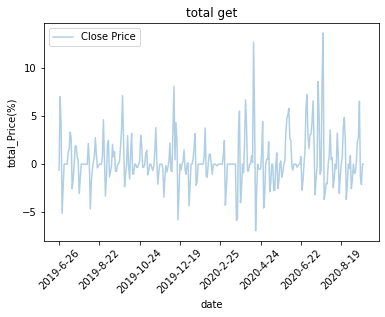

In [20]:
import matplotlib.ticker as ticker

# 選擇日期
date=df_csv.set_index(['Date'])['total']['2019-6-26':]

# x軸間隔
tick_spacing = 40
fig, ax = plt.subplots(1,1)
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

#視覺化 buy and sell 
plt.plot(date, label='Close Price', alpha=0.35)
plt.title('total get')
plt.xticks(rotation=45)
plt.xlabel('date')
plt.ylabel('total_Price(%)')
plt.legend(loc='upper left')
plt.show()

### 合併

In [376]:
import os

file_dir = 'total_company/'
for root, dirs, files in os.walk(file_dir): 
    print(files)


['1213.TW.csv', '1231.TW.csv', '1319.TW.csv', '2330.TW.csv']


In [21]:
'''
要用再取消註解
合併各公司所有total欄位
'''

from functools import reduce
import os

file_dir = 'data/'
for root, dirs, files in os.walk(file_dir): 

    df_list=[]
    for i in tqdm(files):
        df = pd.read_csv('data/'+i)
        df_get_date = local_csv(df)
        df_csv = get_date(df_get_date)
        df_concat = df_csv.drop(columns=['Close','3D'])
        df_concat.columns = ['Date',i.split('.')[0]]
        df_list.append(df_concat)
    
df_combine_per = reduce(lambda df1,df2: pd.merge(df1,df2,on='Date',how="outer"), df_list)

print(df_combine_per)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 874/874 [56:17<00:00,  3.86s/it]


            Date      1101  1101B      1102      1103      1104  1108  \
0     2000-01-04 -4.411882    NaN  0.942635  3.960313  1.980791   0.0   
1     2000-01-05 -4.424902    NaN  0.942635  5.882401  0.995197   0.0   
2     2000-01-06  0.000000    NaN  1.251145  5.741564 -0.497726   0.0   
3     2000-01-07 -2.941259    NaN -9.180255 -6.499965  0.000000   0.0   
4     2000-01-10 -3.021231    NaN -4.934449 -4.411713  0.985390   0.0   
...          ...       ...    ...       ...       ...       ...   ...   
5383  2020-06-25       NaN    NaN       NaN       NaN       NaN   NaN   
5384  2020-06-26       NaN    NaN       NaN       NaN       NaN   NaN   
5385  2020-09-16       NaN    NaN       NaN       NaN       NaN   NaN   
5386  2020-09-17       NaN    NaN       NaN       NaN       NaN   NaN   
5387  2020-09-18       NaN    NaN       NaN       NaN       NaN   NaN   

          1109      1110       1201  ...       9940       9941  9941A  9942  \
0     2.307307  0.000000   6.451613  ...   6

In [22]:
# 要用再取消註解
df_combine_per.to_csv('company_combine_per.csv',encoding='utf-8')

### 圖

In [23]:
df_plt_per = df_combine_per.copy()
df_plt_per.head()

,Date,1101,1101B,1102,1103,1104,1108,1109,1110,1201,...,9940,9941,9941A,9942,9943,9944,9945,9946,9955,9958
0,2000-01-04,-4.411882,NaN,0.942635,3.960313,1.980791,0.0,2.307307,0.000000,6.451613,...,6.106894,0.000000,NaN,NaN,NaN,NaN,4.273601,NaN,NaN,NaN
1,2000-01-05,-4.424902,NaN,0.942635,5.882401,0.995197,0.0,3.065067,0.000000,19.095477,...,14.027977,6.407682,NaN,NaN,NaN,NaN,4.273601,NaN,NaN,NaN
2,2000-01-06,0.000000,NaN,1.251145,5.741564,-0.497726,0.0,-1.937426,-2.956028,18.396226,...,1.792863,12.417542,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
3,2000-01-07,-2.941259,NaN,-9.180255,-6.499965,0.000000,0.0,-1.153653,-1.500184,18.141593,...,-0.053351,-9.433980,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
4,2000-01-10,-3.021231,NaN,-4.934449,-4.411713,0.985390,0.0,-1.562468,0.000000,6.194690,...,0.568422,-6.308522,NaN,NaN,NaN,NaN,-0.819666,NaN,NaN,NaN


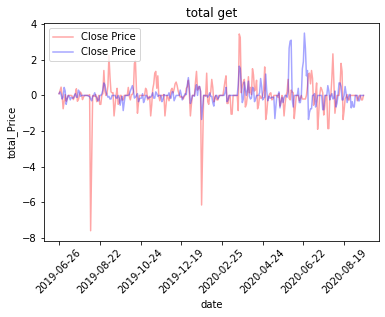

In [395]:
import matplotlib.ticker as ticker

# 選擇日期
date1 = df_plt_per.set_index(['Date'])['1101']['2019-06-26':]
date2 = df_plt_per.set_index(['Date'])['2332']['2019-06-26':]
# x軸間隔
tick_spacing = 40
fig, ax = plt.subplots(1,1)
ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

#視覺化 buy and sell 
plt.plot(date1, label='Close Price', alpha=0.35,color='red')
plt.plot(date2, label='Close Price', alpha=0.35,color='blue')
plt.title('total get')
plt.xticks(rotation=45)
plt.xlabel('date')
plt.ylabel('total_Price')
plt.legend(loc='upper left')
plt.show()